#Section 1

In [52]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
import os
import sklearn as sci
# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [43]:
def convert_to_imshow_format(image):
  # first convert back to [0,1] range from [-1,1] range - approximately... image = image / 2 + 0.5
  image = image.numpy()
  # convert from CHW to HWC
  # from 3x32x32 to 32x32x3
  return image.transpose(1,2,0)

#Loading Datasets
transform = transforms.Compose([transforms.ToTensor()])
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9') 
trainset = torchvision.datasets.SVHN(root='./dataset', split='train', transform=transform, target_transform=None, download=True)
testset = torchvision.datasets.SVHN(root='./dataset', split='test', transform=transform, target_transform=None, download=True)

#Making dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=True)

Using downloaded and verified file: ./dataset/train_32x32.mat
Using downloaded and verified file: ./dataset/test_32x32.mat


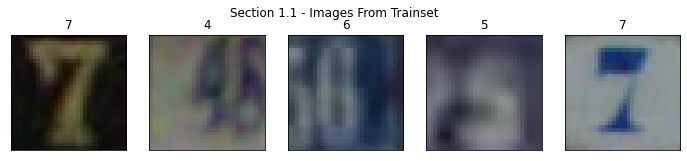

In [44]:
#Display 5 train images
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))

for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

fig.suptitle('Section 1.1 - Images From Trainset')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/output/Section 1.1 - Images From Trainset.png')


In [4]:
#Define the CNN Architecture
class SvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(SvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [5]:
#Training our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = SvhnCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [7]:
def TrainModel(model, model_number):
  for epoch in range(1, epochs + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward + backward + optimize
          outputs = model(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters

          # print statistics
          running_loss += loss.data.item()

      # Normalizing the loss by the total number of train batches
      running_loss /= len(trainloader)

      # Calculate training/test set accuracy of the existing model
      train_accuracy, _ = calculate_accuracy(model, trainloader, device)
      test_accuracy, _ = calculate_accuracy(model, testloader, device)

      log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
      
      # save model
      if epoch % 20 == 0:
          print('==> Saving model ...')
          state = {
              'net': model.state_dict(),
              'epoch': epoch,
          }
          if not os.path.isdir('checkpoints'):
              os.mkdir('checkpoints')
          torch.save(state, f'./checkpoints/svhn{model_number}_cnn_ckpt.pth')

  print('==> Finished Training ...')

Epoch: 1 | Loss: 0.7831 | Training accuracy: 90.434% | Test accuracy: 88.556% | Epoch Time: 36.52 secs
Epoch: 2 | Loss: 0.3041 | Training accuracy: 93.220% | Test accuracy: 91.464% | Epoch Time: 36.44 secs
Epoch: 3 | Loss: 0.2302 | Training accuracy: 94.826% | Test accuracy: 91.895% | Epoch Time: 36.45 secs
Epoch: 4 | Loss: 0.1852 | Training accuracy: 96.343% | Test accuracy: 93.254% | Epoch Time: 36.39 secs
Epoch: 5 | Loss: 0.1529 | Training accuracy: 96.722% | Test accuracy: 93.020% | Epoch Time: 36.55 secs
Epoch: 6 | Loss: 0.1243 | Training accuracy: 97.801% | Test accuracy: 94.161% | Epoch Time: 36.58 secs
Epoch: 7 | Loss: 0.1010 | Training accuracy: 98.275% | Test accuracy: 94.065% | Epoch Time: 36.35 secs
Epoch: 8 | Loss: 0.0817 | Training accuracy: 98.885% | Test accuracy: 94.211% | Epoch Time: 36.53 secs
Epoch: 9 | Loss: 0.0640 | Training accuracy: 99.154% | Test accuracy: 94.061% | Epoch Time: 36.52 secs
Epoch: 10 | Loss: 0.0501 | Training accuracy: 99.361% | Test accuracy: 93

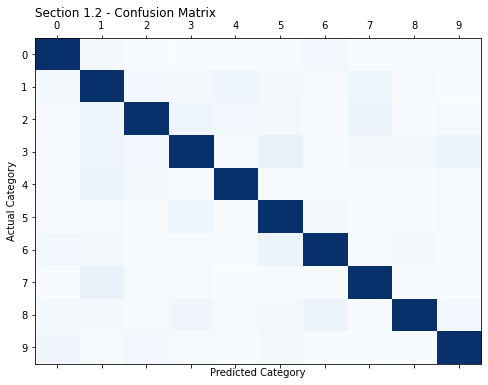

In [8]:
# load model, calculate accuracy and confusion matrix
model = SvhnCNN().to(device) # no need for parameters as we alredy defined them in the class
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
TrainModel(model,1)


# load model, calculate accuracy and confusion matrix
state = torch.load('./checkpoints/svhn1_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.title('Section 1.2 - Confusion Matrix\n', loc='left')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/output/Section 1.2 - Confusion Matrix.png')
plt.show()


In [9]:
#Define the CNN Architecture
class OurSvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(OurSvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),


            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(128, 10),
        )



    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [10]:
#calculating the output size of the convolutional layers, before the FC layers
dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = OurSvhnCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)


model2 = OurSvhnCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

TrainModel(model2,2)


# load model, calculate accuracy and confusion matrix
state = torch.load('./checkpoints/svhn2_cnn_ckpt.pth', map_location=device)
model2.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model2, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.title('Section 1.4 - Confusion Matrix\n', loc='left')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/output/Section 1.4 - Confusion Matrix.png')
plt.show()


torch.Size([1, 128, 4, 4])
torch.Size([1, 2048])
num trainable weights:  551018
Epoch: 1 | Loss: 1.7462 | Training accuracy: 79.266% | Test accuracy: 77.247% | Epoch Time: 33.21 secs


KeyboardInterrupt: ignored

#Section 2

output shape:  torch.Size([1, 1000])
output_predictions 94
output shape:  torch.Size([1, 1000])
output_predictions 90


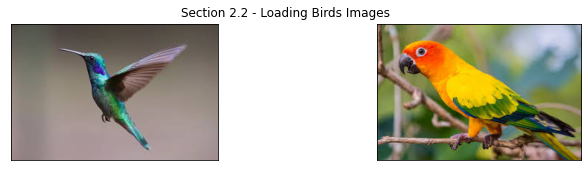

In [62]:
# download and load the pre-trained model
model = torchvision.models.vgg16(pretrained=True, progress=True)
# put in inference mode
model.eval();

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# load images
dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/data')

#Display images

fig, axes = plt.subplots(1, 2, figsize=(12,2.5))
fig.suptitle('Section 2.2 - Loading Birds Images')
for i in range(2):
  axes[i].imshow(plt.imread(f'/content/drive/MyDrive/Colab Notebooks/data/birds/bird_{i}.jpg'))
  axes[i].set_xticks([])
  axes[i].set_yticks([])


# define the pre-processing steps
# image->tensor, normalization and resize
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(size=(224, 224)),
])

# load images
bird0 = Image.open("/content/drive/MyDrive/Colab Notebooks/data/birds/bird_0.jpg")
bird1 = Image.open("/content/drive/MyDrive/Colab Notebooks/data/birds/bird_1.jpg")

# perform pre-processing
input_tensor0 = preprocess(bird0)
input_batch0 = input_tensor0.unsqueeze(0) # create a mini-batch of size 1 as expected by the model
input_tensor1 = preprocess(bird1)
input_batch1 = input_tensor1.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

input_batch = [input_batch0, input_batch1]

model = model.to(device)

for i, batch in enumerate(input_batch):
  # send to device
  batch = batch.to(device)
  # forward pass
  with torch.no_grad():
      output = model(batch)
  output_predictions = output.argmax().item()
  print("output shape: ", output.shape)
  print("output_predictions", output_predictions)
